In [38]:
#remains blank for package installation (if needed)

# Data Science and Machine Learning Coursework

Student Number = 1729296\
Date started = 13/12/2021\
Date finished = 

In [39]:
#import libraries 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skewnorm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy import stats
import tensorflow as tf



#Decoding the reward represented by distributions of Temporal Difference error.

Temporal difference error (TDE) is an algorithm commonly used to calculate reward prediction error in reinforcement learning (RL) paradigms.\
Reinforcement learning is a phenomenon observed in behaving animals, and has inspired a range of contemporary machine learning techniques.\
Now, artificial RL (aRL) can be used to model the neural computations performed as an animal undergoes RL.\
Recently, researchers have extended the TDE algorithm to calculate a distirbution of reward estimates. This distirbutional RL (dRL) is also a good model for dopamine activity in the VTA.\
Here, I use a distributional TD algorithm (dTD) in a guaranteed reward environment, to estimate reward recieved from different reward distributions.\
$\ [1]  δ_{(t,i)} ∶= r_t + γV(S_{t+1}, i)-V(S_t,i)$\
$\ [2]  V(S_t,i)←V(S_t,i)+ α^- δ_{(t,i)}   (δ_{(t,i)}<0) $\
$OR V(S_t,i)←V(S_t,i)+ α^+ δ_{(t,i)} (δ_{(t,i)}>0)$\
I then input the dTDE calculated from this algorithm to a neural network decoder, to see how accurately it can predict the reward used to calculate the dTDE.\
High prediction accuracy indicates that information is shared between the TDE distribution, and the reward distribution used to calculate it. This suggests that similar activity distirbutions observed in biology may also be encoding reward magnitude in a similar way. \
I will train the algorithm on 4 different reward distributions. I will then test the algorithm on each reward within this distirbution. For more details, see code below. 

In [40]:
#assigning alpha and r_dist values to individual 'cells' making these intrinsic cellular properties. 
#this allows us to assess the zero-crossing properties for TDE in individual cells
alpha_pos = np.random.rand(100) 
alpha_neg = np.random.rand(100)
r_dist_pos = np.random.rand(100)
r_dist_neg = np.random.rand(100) 
r_dist = np.random.rand(100)

In [41]:
#reward_distributions

even_dist = np.array((0.2,0.4,0.6,0.8)) #evenly spaced, average of 0.5


#motivation distributions
Low_Reward_magnitude_distribution = np.array((0.0, 0.1, 0.2, 1.7 )) #unevenly spaced, shift towards negative reward values, average of 0.5
High_Reward_magnitude_distribution = np.array((0.05, 0.35, 0.65, 0.95)) #unevenly spaced, shift toward positive reward values, average of 0.5

#Aversion Task 
aversion_magnitude_distribution = np.array((-0.25, -0.10, 0.1, 0.25)) #evenly spaced, featuring aversive values (on same scale as positive), average of 0

##Training the agent

Use the dTD algorithm to train an agent in a guarenteed reward environment.

In [42]:
# an agents that deterministically transitions through a series of states, each 
# of which associated with a random r, selected from the speciied reward distribution
# dtd calculated with standard method (see Dabney, et al., 2020) 

def guaranteed_learner_standard(num_cells, num_states, iterations, reward_dist, alpha = 0.01, gamma =0.2):


  tde = np.zeros((num_states, num_cells)) #empty container to store tde at each state, for each cell
  value_distribution = np.zeros((num_states, num_cells)) #empty container to store estimated value at each state, for each cell
  value_cell = np.zeros((num_cells, num_states)) #empty container to store estimated value for each cell, at each state
  tde_cell = np.zeros((num_cells, num_states)) #empty container to store tde for each cell, at each state

  for trial in range(iterations): #iterates through pre-specified number of training trials
    for state in range(num_states): #transition through each state
      next_state = state+1 #defines next state
      if next_state == (num_states):
        continue  #skips states that do not have stored values (due to 0 indexing)

      r = np.random.choice(reward_dist) #select random reward from reward_dist
      tde[state] = (r) + gamma * value_distribution[next_state] - value_distribution[state] #calculate tde

      for cell in range(num_cells): 
        tde_cell[cell, state] = (r) + gamma * value_distribution[next_state, cell] - value_distribution[state, cell] #calculate tde (store differently)

        #assign different alpha value for value update rule, depending on if tde is positive or negative. 
        #Relative weight of alpha_pos / alpha_neg determines the cell's optimism / pessimism.
        if tde[state,cell] < 0:
          value_distribution[state, cell] += alpha_neg[cell] * tde[state, cell] #value update
          value_cell[cell,state] += alpha_neg[cell] * tde[state, cell] #value update (stored differently)
        elif tde[state,cell] > 0: 
          value_distribution[state, cell] += alpha_pos[cell] * tde[state,cell] #value update
          value_cell[cell,state] += alpha_pos[cell] * tde[state, cell] #value update (stored differently)


 
  return tde, tde_cell, value_distribution, value_cell #return task variables

##Testing the trained agent

Use the dTD algorithm to test the agent (single iteration) on fixed reward for each state.

In [43]:
#an agent that takes a value distribution, calculated using a learner function
#, and transitions deterministically through a series of states, each associated
# with a pre-determined r (should be from the reward_dist that the agent was trained on)

def guaranteed_test_standard(num_cells, num_states, iterations, r, val_dist, val_cell, alpha = 0.01, gamma =0.2):


  tde = np.zeros((num_states, num_cells)) #empty container to store tde at each state, for each cell
  value_distribution = val_dist #value distribution taken from previously trained agent
  tde_cell = np.zeros((num_cells, num_states)) # #empty container to store tde for each cell, at each state
  value_cell = val_cell  #empty container to store estimated value for each cell, at each state

  for state in range(num_states): #transition through each states 
    next_state = state+1 #defines next state
    if next_state == (num_states): 
      continue #skips states that do not have stored values (due to 0 indexing)
    tde[state] = (r) + gamma * value_distribution[next_state] - value_distribution[state] #calculate tde
    for cell in range(num_cells): 
      tde_cell[cell, state] = (r) + gamma * value_distribution[next_state, cell] - value_distribution[state, cell] #calculate tde (store differently)
      
      #assign different alpha value for value update rule, depending on if tde is positive or negative. 
      #Relative weight of alpha_pos / alpha_neg determines the cell's optimism / pessimism.
      if tde[state,cell] < 0:
        value_distribution[state, cell] += alpha_neg[cell] * tde[state, cell] #value update
        value_cell[cell,state] += alpha_neg[cell] * tde[state, cell] #value update (stored differently)
      elif tde[state,cell] > 0: 
        value_distribution[state, cell] += alpha_pos[cell] * tde[state,cell] #value update
        value_cell[cell,state] += alpha_pos[cell] * tde[state, cell] #value update (stored differently)


  return tde_cell, value_cell #return task variables

##Testing the assumptions of dRL

Assymetric learning \
Differential zero crossing

In [44]:
def make_mean_list(num_cells, array):
  mean_list = [] #create empty list

  for n in range(num_cells): #iterate through number of cells
    mean_list.append(np.mean(array[n])) #return average statistic, for each cell, over each state
    
  return mean_list #returns list

###Zero Crossing

In [45]:
#plots KDE and violin plots for training and test (with each r in a predefined distribution)
def zero_crossing_plots(num_cells, num_states, iterations, reward_dist, test_dist, learner_function, tester_function, kernal_density_estimation = True, violin_plots = True):
  

  tde, tde_cell, value_distribution, value_cell = learner_function(num_cells, num_states, iterations, reward_dist) #train agent

  mean_tde_cell = make_mean_list(num_cells, tde_cell) #make a list of mean tde (across all states) for each cell. 

  r_dictionary = {} #create empty r dictionary
  
  for n, r in enumerate(test_dist): #iterates through reward_distribution for test (returning index and r)
    
    tde_cell_new, value_cell_new = tester_function(num_cells, num_states,1, r, value_distribution, val_cell = value_cell) #test with r
    r_tde_cell = make_mean_list(num_cells, tde_cell_new) #make a list of mean tde(across all states) for each cell with this r
    r_dictionary[n] = r_tde_cell #store list for each r in r_index:list dict
   
  
  #for each test reward, create an array from the mean tde for each cell across each state.
  mean_tde_cell = np.asarray(mean_tde_cell)  
  small_reward = np.asarray(r_dictionary[0])
  small_med_reward = np.asarray(r_dictionary[1])
  big_med_reward = np.asarray(r_dictionary[2])
  big_reward = np.asarray(r_dictionary[3])


  if kernal_density_estimation == True: #plot KDE 
    full_labels =[] #empty list for the label (need to label the tde for each cell with the r used to calculate it)
    full_list = np.concatenate([mean_tde_cell, small_reward, small_med_reward, big_med_reward, big_reward]) #create concatenated list of tde for each reward
    for n in range(num_cells): #iterate through length of list and append a reward label for each observaion
      full_labels.append('mean reward')
    for n in range(len(small_reward)):
      full_labels.append('small_reward')
    for n in range(len(small_med_reward)): 
      full_labels.append('medium small reward')
    for n in range(len(big_med_reward)): 
      full_labels.append('medium big reward')
    for n in range(len(big_reward)): 
      full_labels.append('big_reward')

    mean_cell_tde_zipped = list(zip(full_labels,full_list)) #create zipped list that combines labels with tde values
    mean_cell_tde_df = pd.DataFrame(mean_cell_tde_zipped, columns=['labels', 'tde']) #convert to pandas df
    sns.displot(data = mean_cell_tde_df, x = 'tde', hue = 'labels', kind = 'kde') #plot, colouring different curves based on r used to calculate tde
  
  if violin_plots == True: #plot violin plots
    plot_data = list([mean_tde_cell, small_reward, small_med_reward, big_med_reward, big_reward]) #list of lists

    fig, ax = plt.subplots() #define page and axes

    xticklabels = ['mean reward', 'small reward', 'medium small reward', 'medium large reward', 'large reward'] #list of axis labels
    ax.set_xticks([1, 2, 3, 4, 5]) #axis ticks for labels
    ax.set_xticklabels(xticklabels, rotation=90) #rotate labels for readability

    ax.violinplot(plot_data, showmedians=True) #plot violin with the arguments defined above
    plt.axhline(y=0)
    plt.ylabel('TDE')


  #perform krusal wallis (if not normal) and one way ANOVA (if normal) to test if populations are significantly different.
  print(stats.kruskal(mean_tde_cell, small_reward, small_med_reward, big_med_reward, big_reward))
  print(stats.f_oneway(mean_tde_cell, small_reward, small_med_reward, big_med_reward, big_reward))



###Assymetric Learning

In [46]:
#plots a scatter plot, (reminscient of those seen in Dabney, et al., 2020) which compares predicted value to the relative weight of alpha+/alpha-.

def Distribution_coding_plot(num_cells, num_states, iterations, reward_dist, learner_function, new = False, target = False, target_dest = None, extra_iterations = None): 
  alpha_weights =[] #empty list of alpha weights (within which the relative alpha+ / alpha- ratio will be stored)

  tde, tde_cell, value_distribution, value_cell = learner_function(num_cells, num_states, iterations, reward_dist) #train agent
  value_cell_mean = make_mean_list(num_cells, value_cell) #calculates the mean value for each cell, across each state


  for cell in range(num_cells): #iterate through cells
    alpha_weights.append(alpha_pos[cell]/(alpha_pos[cell] + alpha_neg[cell])) #calculates relative weight of alpha+ / alpha- 

  
  
  model = np.poly1d(np.polyfit(alpha_weights, value_cell_mean, 3))#runnign and fitting cubic regression
  polyline = np.linspace(0, 1, 50) #values to be predicted by cubic regression

  alpha_value_dict = {'asymmetric scaling factor':alpha_weights,'Value':value_cell_mean} #create dictionary of alpha_weight, value pairs
  alpha_value_df = pd.DataFrame(alpha_value_dict) #turn dictionary into df
  print(alpha_value_df)


  fig, ax = plt.subplots() #define axes
  ax.plot(polyline, model(polyline), color = 'black', linewidth=1.5,) #plot lobf
  ax.scatter('asymmetric scaling factor', 'Value', #plot scatter
             c = 'asymmetric scaling factor', #colour points according to relative alpha+/- weight
             data = alpha_value_df) #take data from df
  ax.set_xlabel('Assymetric Scaling Factor') #set x label
  ax.set_ylabel('Value') #set y label
 
  plt.show() #show plot

  #isolate results from non-linear regression
  results = {}
  coeffs = np.polyfit(alpha_weights, value_cell_mean, 3)
  p = np.poly1d(coeffs)
    
  yhat = p(alpha_weights)
  ybar = np.sum(value_cell_mean)/len(value_cell_mean)
  ssreg = np.sum((yhat-ybar)**2)
  sstot = np.sum((value_cell_mean - ybar)**2)
  results['r_squared'] = ssreg / sstot
  print(results['r_squared'])



KruskalResult(statistic=367.3401791616768, pvalue=3.158567513293416e-78)
F_onewayResult(statistic=333.51494560298596, pvalue=5.9197466885577836e-139)


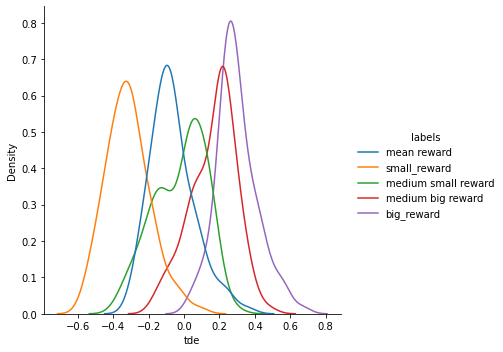

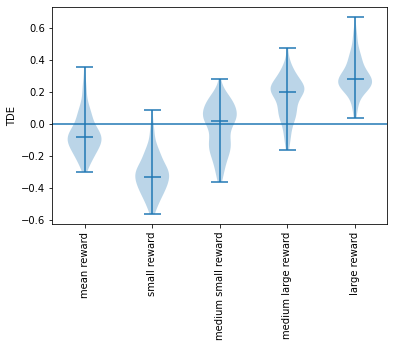

In [47]:
#train and test dTD algorithm on even reward distribution

zero_crossing_plots(100, 40, 1000, even_dist, even_dist, guaranteed_learner_standard, guaranteed_test_standard)

    asymmetric scaling factor     Value
0                    0.391953  0.540410
1                    0.552251  0.607710
2                    0.801939  0.756408
3                    0.712777  0.699664
4                    0.787899  0.747780
..                        ...       ...
95                   0.232684  0.434622
96                   0.702578  0.696761
97                   0.607440  0.643339
98                   0.470228  0.544919
99                   0.271179  0.441226

[100 rows x 2 columns]


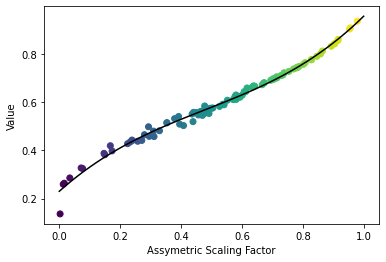

0.9905787711998564


In [48]:
Distribution_coding_plot(100, 40, 1000, even_dist, guaranteed_learner_standard)

#Decoding 

In [49]:
# 'repeat' the testing experiments multiple times, to generate a breadth of observations for each reward magnitude which can be thus used in the decoder.

def train_and_test(num_cells, num_states, iterations, reward_dist, test_dist, test_repeats, learner_function, tester_function, test_number = 2): 
  
  tde, tde_cell, memory, memory_cell = learner_function(num_cells, num_states, iterations, reward_dist) # train agent

  
  val_input = np.copy(memory) #crate a copy of stored value estimates (memory / memory cell; to use during test) to avoid pointing and thus unwanted learning during testing. 
  val_cell_input = np.copy(memory_cell)


  rows = (len(reward_dist)) * test_repeats #calculate rows of final df (including all test repeats for each r in reward dist)

  r_array = np.zeros((rows, num_cells)) #create empty container to store tde for each cell at each reward, and each repeat.
  val_array = np.zeros((rows, num_cells)) #create empty contasiner to store value for each cell at each reward, and each repeat.
  

  index = 0  #set index to 0
  for reward in test_dist: #iterate through each reward in reward distribution
    for test in range(test_repeats): #iterate through each test in predefined number of repeats
      r = reward #set r to reward in reward distribution
      tde_cell_test, output_v = tester_function(num_cells, num_states,1, r, val_input, val_cell_input) #calculate tde and value from test function, using r
      r_array[index] = np.asarray(make_mean_list(num_cells, tde_cell_test)) #store tde in array
      val_array[index] = np.asarray(make_mean_list(num_cells, output_v)) #store val in array

      val_input = np.copy(memory) #reset stored value estimates (memory / memory cell) to 'memory' to avoid pointing and thus unwanted learning during testing. 
      val_cell_input = np.copy(memory_cell)

      index += 1 #increase index by 1

  r_df = pd.DataFrame(r_array) #convert tde array to df
  val_df = pd.DataFrame(val_array) #convert value array to df

  label_list = [] #create list for reward labels
  for label in range(len(test_dist)): #iterate rewards in reward distirbution
    for test in range(test_repeats): #iterate through repeats in predefined number of repeats
      label_list.append(label) #append label (e.g 0/1/2/3) for each reward to label list.

  r_df['target'] = label_list #add label list to tde df
  val_df['target'] = label_list #add label list to val df

  
  return r_df, val_df #return variables

In [50]:
model = tf.keras.Sequential([ #define forward neural network
tf.keras.Input((100,)), #define input layer with 100 inputs (for each cell)
tf.keras.layers.Dense(50, activation=tf.nn.relu, #50 cell wide dense layer, with Relu activation function
                        bias_regularizer=tf.keras.regularizers.L2(0.01)), #apply L2 regularizer to avoid over fitting and autocorrelation
tf.keras.layers.Dropout(0.2, input_shape = (50, )), #add dropout layer to aovid over reliance on any single cell
tf.keras.layers.Dense(50, activation=tf.nn.relu,
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
tf.keras.layers.Dense(4, activation=tf.nn.softmax) #define softmax output function
  ])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #compile model
model.save_weights('model.h5') #store weights for naive model

In [ ]:
# create data for decoder and parse through decoder, with predefined naive weights.

r_squ_even = np.zeros((5,10)) #create empty array for model score.
for repeat in range(10):  #iterate trough 'test' repeats for decoder
  r_df_even, val_df_even, =train_and_test(100, 40, 1000, even_dist, even_dist, 1000, guaranteed_learner_standard, guaranteed_test_standard) #train and test model (create decoder data)

  val_df_even['target'] = val_df_even.target.astype('category') #convert target data to categorical (to be interpreted as such by decoder)

  cell_index = np.linspace(0,99,100) #create a list from 0-99 to extract x variable

  X = np.copy(val_df_even[cell_index]) #create x variable (copy of val df from test/train function to avoid pointing)

  y = np.copy(np.asarray(val_df_even['target'])) #create y variable (copy of target, as array, to avoid pointing)

  X_train, X_test, y_train, y_test = train_test_split(X, y) #split x and y variables into test and train batches.

  train = tf.data.Dataset.from_tensor_slices((np.copy(X_train), np.copy(y_train))) #define train data as tensor
  train = train.repeat().shuffle(1000).batch(32) #shuffle train data
  test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1) #define test data as tensor

  #define model
  model = tf.keras.Sequential([ 
  tf.keras.Input((100,)),
  tf.keras.layers.Dense(50, activation=tf.nn.relu, 
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dropout(0.2, input_shape = (50, )),
  tf.keras.layers.Dense(50, activation=tf.nn.relu,
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #compile model

  model.load_weights('model.h5') #apply sotred model weights

  model.fit(
    train, #fit model to train data
    validation_data=test, #evaluate using test data
    steps_per_epoch=180, #apply 180 steps per epoch
    epochs=5,) #run for 5 epochs
  
  for num, n in enumerate(model.history.history['accuracy']): #iterate through model accuracy
    r_squ_even[num, repeat] = n #store model accuracy in array, for each epoch (num) for this repeat.
    

r_squ_even = pd.DataFrame(r_squ_even) #convert to df
print(r_squ_even) #print df
  

In [ ]:
r_squ_even['r squared'] = r_squ_even.mean(axis = 1) #create mean score column

In [ ]:

r_squ_even['dist'] = 'even' #apply label 'even' for this df

r_squ_even 

In [ ]:
#repeat previous step for low reward distribution

r_squ_low = np.zeros((5,10))
for repeat in range(10): 
  r_df_low, val_df_low=train_and_test(100, 40, 1000, Low_Reward_magnitude_distribution, Low_Reward_magnitude_distribution, 1000, guaranteed_learner_standard, guaranteed_test_standard)

  val_df_low['target'] = val_df_low.target.astype('category')

  cell_index = np.linspace(0,99,100)

  X = np.copy(val_df_low[cell_index])

  y = np.copy(np.asarray(val_df_low['target']))

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  train = tf.data.Dataset.from_tensor_slices((np.copy(X_train), np.copy(y_train)))
  train = train.repeat().shuffle(1000).batch(32)
  test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1) 

  model = tf.keras.Sequential([
  tf.keras.Input((100,)),
  tf.keras.layers.Dense(50, activation=tf.nn.relu, 
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dropout(0.2, input_shape = (50, )),
  tf.keras.layers.Dense(50, activation=tf.nn.relu,
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.load_weights('model.h5')

  model.fit(
    train,
    validation_data=test,
    steps_per_epoch=150,
    epochs=5,)
  
  for num, n in enumerate(model.history.history['accuracy']):
    r_squ_low[num, repeat] = n
    

r_squ_low = pd.DataFrame(r_squ_low)
print(r_squ_low)
  

In [ ]:
r_squ_low['r squared'] = r_squ_low.mean(axis = 1)

In [ ]:
r_squ_low['dist'] = 'low'

r_squ_low

In [ ]:
#repeat previous step for high reward distribution

r_squ_high = np.zeros((5,10))
for repeat in range(10): 
  r_df_high, val_df_high=train_and_test(100, 40, 1000, High_Reward_magnitude_distribution, High_Reward_magnitude_distribution, 1000, guaranteed_learner_standard, guaranteed_test_standard)

  val_df_high['target'] = val_df_high.target.astype('category')

  cell_index = np.linspace(0,99,100)

  X = np.copy(val_df_high[cell_index])

  y = np.copy(np.asarray(val_df_high['target']))

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  train = tf.data.Dataset.from_tensor_slices((np.copy(X_train), np.copy(y_train)))
  train = train.repeat().shuffle(1000).batch(32)
  test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1) 

  model = tf.keras.Sequential([
  tf.keras.Input((100,)),
  tf.keras.layers.Dense(50, activation=tf.nn.relu, 
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dropout(0.2, input_shape = (50, )),
  tf.keras.layers.Dense(50, activation=tf.nn.relu,
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.load_weights('model.h5')

  model.fit(
    train,
    validation_data=test,
    steps_per_epoch=150,
    epochs=5,)
  
  for num, n in enumerate(model.history.history['accuracy']):
    r_squ_high[num, repeat] = n
    

r_squ_high = pd.DataFrame(r_squ_high)
print(r_squ_high)

In [ ]:
r_squ_high['r squared'] = r_squ_high.mean(axis = 1)

In [ ]:
r_squ_high['dist'] = 'high'

r_squ_high

In [ ]:
#repeat previous step for aversive distribution

r_squ_aversive = np.zeros((5,10))
for repeat in range(10): 
  r_df_aversive, val_df_aversive=train_and_test(100, 40, 1000, aversion_magnitude_distribution, aversion_magnitude_distribution, 1000, guaranteed_learner_standard, guaranteed_test_standard)

  val_df_aversive['target'] = val_df_aversive.target.astype('category')

  cell_index = np.linspace(0,99,100)

  X = np.copy(val_df_aversive[cell_index])

  y = np.copy(np.asarray(val_df_aversive['target']))

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  train = tf.data.Dataset.from_tensor_slices((np.copy(X_train), np.copy(y_train)))
  train = train.repeat().shuffle(1000).batch(32)
  test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1) 

  model = tf.keras.Sequential([
  tf.keras.Input((100,)),
  tf.keras.layers.Dense(50, activation=tf.nn.relu, 
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dropout(0.2, input_shape = (50, )),
  tf.keras.layers.Dense(50, activation=tf.nn.relu,
                        bias_regularizer=tf.keras.regularizers.L2(0.01)),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.load_weights('model.h5')

  model.fit(
    train,
    validation_data=test,
    steps_per_epoch=150,
    epochs=5,)
  
  for num, n in enumerate(model.history.history['accuracy']):
    r_squ_aversive[num, repeat] = n
    

r_squ_aversive = pd.DataFrame(r_squ_aversive)
print(r_squ_aversive)

In [ ]:
r_squ_aversive['r squared'] = r_squ_aversive.mean(axis = 1)

In [ ]:
r_squ_aversive['dist'] = 'aversive'

r_squ_aversive

In [ ]:
frames = [r_squ_even, r_squ_low, r_squ_high, r_squ_aversive] #create list of each df
r_squ = pd.concat(frames) #create concatenated df with all dfs included.
r_squ.reset_index(drop=True, inplace=True) #reset index so it goes in ascending order

In [ ]:
epochs = [1,2,3,4,5, 1, 2,3,4,5,1,2,3,4,5,1,2,3,4,5] #create list of epoch labels
r_squ['epochs'] = epochs #add epoch labels

In [ ]:
#create learning curves for each distribution
sns.lineplot(data=r_squ, x="epochs", y="r squared", hue = 'dist')